In [1]:
import sympy
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import astropy.constants as c
import scipy
import scipy.optimize
from scipy import integrate

plt.style.use('vedant')

In [2]:
# READ IN STELLAR MODEL FROM SED NOTEBOOK

bestfit = np.loadtxt('txt/bestfit.txt')

## Dust Temperatures (Xu et al. 2018)

In [3]:
# Large grain approximation
# Input in K, Rsun, Rsun

def T_bb(T_star, R_star, r):
    return 1.2e3 * (T_star / 15900) * (R_star / 0.013)**(1/2) * (r / 1.16)**(-1/2)

# Small grain approximation
# Input in K, Rsun, Rsun

def T_rayl(T_star, R_star, r):
    return 2e3 * (T_star / 15900) * (R_star / 0.013)**(2/5) * (r / 1.16)**(-2/5)

In [4]:
# Change these values based on parameter fit and lc analysis

T_star = bestfit[0] # K
R_star = bestfit[1] # Rsun
M_star = 0.5

## Get disk radius from IR Excess, assuming T_bb

T_excess = 700 # K
T_inner = 1400

###########

r_grid = np.linspace(5, 35, 1000)

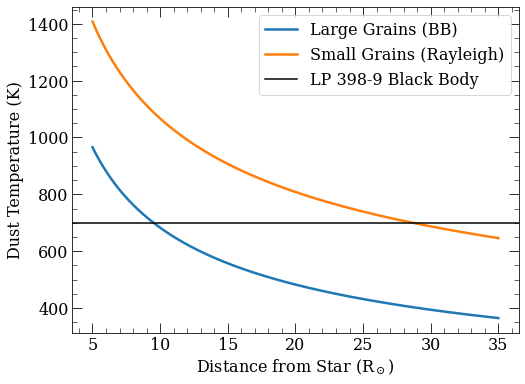

In [5]:
plt.plot(r_grid, T_bb(T_star, R_star, r_grid), label = 'Large Grains (BB)', lw = 2.5)
plt.plot(r_grid, T_rayl(T_star, R_star, r_grid), label = 'Small Grains (Rayleigh)', lw = 2.5)

plt.ylabel('Dust Temperature (K)')
plt.xlabel('Distance from Star ($R_\odot$)')

plt.axhline(T_excess, color = 'k', linestyle = '-', label = 'LP 398-9 Black Body')
#plt.axhline(T_inner, color = 'k', linestyle = '--', label = 'LP 398-9 Inner Disk')

#plt.axvline(R_LC, color = 'k', linestyle = '--', label = 'LC Keplerian Radius')

plt.legend()
plt.savefig('fig/dust_temperature.jpg', dpi = 300)

## Dust Mass

In [6]:
def planck_func(wl, T):
    
#     R = R * c.R_sun
#     D = (1000 / bestfit[2]) * c.pc
    
    nu = c.c / (wl)
    
    sa =  np.pi #* R**2 / D**2 # UN NORMALIZED 
    
    t1 = 2 * c.h * nu**3 / c.c**2
    t2 = np.exp(c.h * nu / (c.k_B * T)) - 1
    
    return (sa * t1 / t2).to(u.Jy)

In [7]:
def dust_mass(obs_flux, obs_wl, distance, rho_dust, T_dust, a_dust, Q_abs):
    num = obs_flux * 4 * a_dust * rho_dust * distance**2
    denom = 9 * Q_abs * planck_func(obs_wl, T_dust)
    
    return num / denom

In [29]:
distance = 840 * u.pc # Gaia EDR3
rho_dust = 2 * u.g / u.cm**3 # Amorphous carbon, Lagadec 2005
T_dust = 710 * u.K # BB Fit
a_dust = 0.22 * u.micron # Optical Extinction
Q_abs = 0.01 # Voshchinnokov 2006

# W1

obs_flux = 2.14662794e-04 * u.Jy # W1
obs_wl = 3.4 * u.micron # W1

# W2

obs_flux2 = 2.99137111e-04 * u.Jy
obs_wl2 = 4.6 * u.micron

In [30]:
# 1) Dust mass from grain density and absorption efficiency

Md_W1 = dust_mass(obs_flux, obs_wl, distance, 
          rho_dust, T_dust, a_dust, Q_abs).to(u.g)

Md_W2 = dust_mass(obs_flux2, obs_wl2, distance, rho_dust, T_dust, a_dust, Q_abs).to(u.g)

print(Md_W1)
print(Md_W2)

3.433991957215621e+20 g
2.479053972355295e+20 g


In [31]:
(Md_W1).to(u.Msun)

<Quantity 1.72700408e-13 solMass>

In [32]:
# 2) Dust mass from opacity (assuming Draine opacity at 3.4 µm)

kappa_dust = 500 * u.cm**2 / u.g

def dust_mass_kappa(obs_flux, obs_wl, distance, kappa_dust, T_dust):
    num = obs_flux * distance**2
    denom = kappa_dust * planck_func(obs_wl, T_dust)
    
    return num / denom

# W1

print(dust_mass_kappa(obs_flux, obs_wl, distance, kappa_dust, T_dust).to(u.g))

# W2

print(dust_mass_kappa(obs_flux2, obs_wl2, distance, kappa_dust, T_dust).to(u.g))

3.5120372289705234e+20 g
2.535396108090643e+20 g


In [33]:
# 3) Dust mass from BB emission area (normalization) and opacity (Jura 2003)

disk_area = np.pi * (5 * u.Rsun)**2

print((disk_area / kappa_dust).to(u.g))

7.602630502662764e+20 g


# PR Drag

In [41]:
def Fpr(r_grain, L, M, R_orb):
    t1 = r_grain**2 * L / (4 * c.c**2)
    t2 = np.sqrt(c.G * M / R_orb**5)
    return (t1 * t2).to(u.N)

In [77]:
Rstar = bestfit[1] * u.Rsun
Tstar = bestfit[0] * u.K
Lstar = (c.sigma_sb * (4 * np.pi * Rstar**2) * Tstar**4).to(u.Watt) # Stefan Boltzmann
Mstar = 0.5 * u.Msun


r_grain = 0.23 * u.micron
R_orb = 0.5 * u.Rsun

rho_grain = 3 * u.g / u.cm**3
m_grain = ((4/3) * np.pi * r_grain**3 * rho_grain).to(u.g)

In [78]:
fpr = Fpr(r_grain, Lstar, Mstar, R_orb)
fpr

<Quantity 1.42977279e-17 N>

In [79]:
apr = (Fpr(r_grain, Lstar, Mstar, R_orb) / m_grain).to(u.m/u.s**2)
apr

<Quantity 0.09351336 m / s2>

In [80]:
(apr * (100_000 * u.yr)**2).to(u.Rsun)/2

<Quantity 6.69313508e+14 solRad>

# Jura Disk Model

In [14]:
def jura_disk(wl, D, i, T_star, R_star, T_in, T_out):
    
    nu = c.c / (wl * 1e-10 * u.m)
    R_star = R_star * c.R_sun
    D = D * c.pc
    T_star = T_star * u.K
    T_in = T_in * u.K
    T_out = T_out * u.K
    
    t1 = 12 * np.pi**(1/3) * R_star**2 * np.cos(i) / D**2
    t2 = (2 * c.k_B * T_star / (3 * c.h * nu)) ** (8 / 3)
    t3 = c.h * nu**3 / c.c**2
    
    xmin = c.h * nu / (c.k_B * T_in)
    xmax = c.h * nu / (c.k_B * T_out)

    fn = lambda x: x**(5/3) / (np.exp(x) - 1)
    t4 = integrate.quad(fn, xmin.value, xmax.value)[0]
        
    return (t1*t2*t3*t4).to(u.Jy).value

def disk_model(wl, D, i, T_star, R_star, T_in, T_out):
    return np.array([jura_disk(wli, D, i, T_star, R_star, T_in, T_out) for wli in wl]) #* u.Jy

In [15]:
def T_ring(R_star, T_star, r):
    return (2 / (3 * np.pi))**(1/4) * (R_star / r)**(3/4) * T_star

In [16]:
T_ring(R_star, T_star, 0.9)

1488.8730947129702

In [17]:
wl = np.logspace(3, 10, 100)

In [18]:
D = 100
i = 0
R_star = bestfit[1]
T_star = bestfit[0]
T_in = 1200
T_out = 205

sed = disk_model(wl, D, i, T_star, R_star, T_in, T_out)

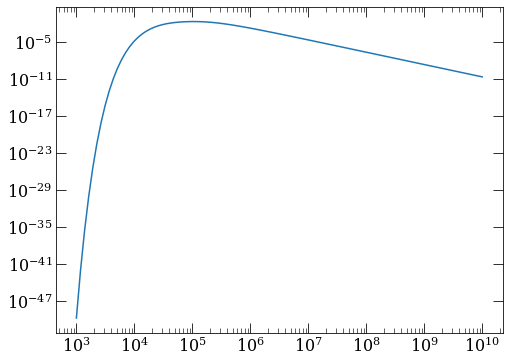

In [19]:
plt.plot(wl, sed)

plt.yscale('log')
plt.xscale('log')

## Tidal Radius

In [73]:
R_star = 0.22 * u.Rsun

rho_star = 0.5 * c.M_sun / ((4/3) * np.pi * (R_star)**3)
rho_a = (2 * u.g / (u.cm)**3).to(u.kg/u.m**3)
Ctide = 1

R_tide = (Ctide * (rho_star / rho_a)**(1/3) * R_star).to(u.Rsun) #* u.R_sun

In [78]:
R_tide

<Quantity 0.70636705 solRad>

In [80]:
R_tide / R_star

<Quantity 3.21075932>

In [75]:
rho_star / rho_a

<Quantity 1.1145236e+28 m3 / solRad3>

In [76]:
rho_star.to(u.g / u.cm**3)

<Quantity 66.199278 g / cm3>

In [77]:
rho_a.to(u.g / u.cm**3)

<Quantity 2. g / cm3>